In [205]:
import re
import csv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
import os

files = os.listdir("Data/GoT_dyn_ts10")

def get_active_nodes(G):
    activenodes = set()
    for edge in G.edges(data=True):
        #print(edge)
        activenodes.add(edge[0])
        activenodes.add(edge[1])
    return activenodes

def episode(s, e, name = 'GoT_S0'):
    if e < 10:
        stt = name +str(s)+'E0'+str(e) 
    else:
        stt = name +str(s)+'E'+str(e) 
    #print(stt)
    edic = {}
    for f in files:
        if f.startswith(stt):
            #en = int(f[11:14])
            en = int(f.split('.')[0].split('_')[-1])
            #print(f, en)
            edic[en] = f
    return edic
 
def readG(f, path = 'Data/GoT_dyn_ts10/'):
    #print(f)
    return nx.read_graphml( path + f)

def histogram(G):
    hist = {}
    dict = {}
    for node in G.nodes(data=True):
        dict[node[0]] = node[1]['label']
        
    #print(dict)
    for edge in G.edges(data=True):
        for i in range(2):
            node = dict[edge[i]]
            #print(node)
            try:
                hist[node] += 1
            except:
                hist[node] = 1
    return hist

def aggregate_density(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e, name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
   
    total_edges = 0
    potential_edges = 0
    
    #print(sorted_x)
    for k, v in sorted_x:
        g = readG(v, path)
        
        num_actnodes = len(get_active_nodes(g))
        num_edges = len(g.edges(data=True))
        
        total_edges += num_edges
        potential_edges += num_actnodes*(num_actnodes-1)/2
       
    return total_edges/potential_edges

# TODO: remove the nodes with small strength, re-calculate density again
# density = sum(edge weights) / (num_10s * active_nodes * (active_nodes - 1) / 2)
def weighted_density(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e, name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
   
    total_edges = 0
    num_episodes = len(sorted_x)
    potential_edges = 0
    
    active_nodes = set()
    
    #print(sorted_x)
    for k, v in sorted_x:
        g = readG(v, path)
        
        node_in_one_episode = get_active_nodes(g)
        active_nodes = active_nodes.union(node_in_one_episode)
        num_edges = len(g.edges(data=True))
        total_edges += num_edges
    
    #print(len(active_nodes))
    num_actnodes = len(active_nodes)
    potential_edges = num_episodes * num_actnodes*(num_actnodes-1)/2
       
    return total_edges/potential_edges

def average_density(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e,name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
    #print(sorted_x)
    dns = []
    #print(sorted_x)
    for k, v in sorted_x:
        g = readG(v, path)
        #h = histogram(g)
        #print(v)
        dns.append(nx.density(g))
    return sum(dns)/len(dns)
    
def node_dict(g):
    dict = {}
    for node in g.nodes(data=True):
        dict[node[0]] = node[1]['label']
    return dict
            
def active_nodes(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e, name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
    
    act_nodes = set()
    #print(sorted_x)
    for k, v in sorted_x:
        g = readG(v, path)
        activenodes = get_active_nodes(g)
        nodedict = node_dict(g)
        for n in activenodes:
            act_nodes.add(nodedict[n])
    #print(act_nodes)
    return act_nodes
     
def degree_data(g):
    G_deg = nx.degree_histogram(g)
    G_deg_sum = [a * b for a, b in zip(G_deg, range(0, len(G_deg)))]
    avg_degree = sum(G_deg_sum) / g.number_of_nodes()
    return avg_degree
    
def average_degree(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e,name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
    
    degrees = []
    act_nodes = set()
    #print(sorted_x)
    for k, v in sorted_x:
        g = readG(v, path)
        avg_degree = degree_data(g)
        degrees.append(avg_degree)
        
    #print(degrees)
    return sum(degrees)/len(degrees)
    
def get_corr(review):
    dict = {'Network Metrics':[],
            'Correlation':[],
            'pValue':[]
           }

    for col in ['Weighted_Density', 'Active_Nodes', 'Degrees', 'Strength', 'Closeness', 'Harmonic','Efficiency','Transitivity','Clusters', 'Components']:
        corr, pval = pearsonr(review[col], review['Review'])
        dict['Network Metrics'].append(col)
        dict['Correlation'].append(corr)
        dict['pValue'].append(pval)

    df_corr = pd.DataFrame(dict)
    return df_corr


def get_corr_spearman(review):
    dict = {'Network Metrics':[],
            'Correlation':[],
            'pValue':[]
           }
 
    for col in ['Weighted_Density', 'Active_Nodes', 'Degrees', 'Strength', 'Closeness', 'Harmonic','Efficiency','Transitivity','Clusters', 'Components']:
        corr, pval = spearmanr(review[col], review['Review'])
        dict['Network Metrics'].append(col)
        dict['Correlation'].append(corr)
        dict['pValue'].append(pval)

    df_corr = pd.DataFrame(dict)
    return df_corr


def aggregate_graph(s, e, name , path ):
    edic = episode(s,e,name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
    
    degrees = []
    count = len(sorted_x)
    act_nodes = set()
    
    newg = {}
    #print(sorted_x)
    max_weight = 0
    for k, v in sorted_x:
        g = readG(v, path)
    
        nd = node_dict(g)
        for node1, node2, data in g.edges(data=True):
            node1  = nd[node1]
            node2  = nd[node2]
            weight = data['weight']
            
            try:
                newg[(node1, node2)] += weight
            except:
                newg[(node1, node2)]  = weight
            
            max_weight = max(max_weight, newg[(node1, node2)])
    
    #scale weights
    for k in newg:
        newg[k] = newg[k] / count
        
    return newg, count, max_weight/count
        
def nx_aggregate_graph(s, e, name , path ):
    edic = episode(s,e,name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
    
    degrees = []
    count = len(sorted_x)
    act_nodes = set()
    
    newg = {}
    #print(sorted_x)
    max_weight = 0
    for k, v in sorted_x:
        g = readG(v, path)
    
        nd = node_dict(g)
        for node1, node2, data in g.edges(data=True):
            node1  = nd[node1]
            node2  = nd[node2]
            weight = data['weight']
            
            try:
                newg[(node1, node2)] += weight
            except:
                newg[(node1, node2)]  = weight
            
            max_weight = max(max_weight, newg[(node1, node2)])
    
    
    nxG = nx.Graph()
    max_weight = max_weight/count
    for k in newg:        
        #remove small weight edges 
        if newg[k] / count <  max_weight * 0.05:
            continue
        nxG.add_edge(k[0], k[1], weight = newg[k] / count)
        
    newg2 = {}
    #scale weights
    for k in newg:
        #remove small weight edges 
        if newg[k] / count <  max_weight * 0.05:
            continue
        newg2[k] = newg[k] / count
        
    return newg2, count, max_weight/count, nxG

#print(episode_active_nodes(1,1))
def average_data(dictData):
    total = 0
    cnt = 0
    for k in dictData:
        total += dictData[k]
        cnt += 1
    avg_data = total / cnt
    
    return avg_data
    
def average_strength(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    g, count, max_weight, nxG = nx_aggregate_graph(s, e, name, path)
    
    strength = {}
    sum_weight = 0
    sum_degree = 0
    node_list = set()

    for k in g:
        node1, node2 = k
        v = g[k]
        
        sum_weight += v
        sum_degree += 2
        node_list.add(node1)
        node_list.add(node2)
    
    
    cnt_nodes = len(node_list)
    
    avg_closeness = average_data(nx.closeness_centrality(nxG))
    avg_harmonic = average_data(nx.harmonic_centrality(nxG))
    glb_efficiency =  nx.global_efficiency(nxG)
    transitivity = nx.transitivity(nxG)
    clusters = average_data(nx.clustering(nxG))
    components = nx.number_connected_components(nxG)
 
    return sum_weight/cnt_nodes,  sum_degree/cnt_nodes, cnt_nodes, sum_weight * 2/cnt_nodes/(cnt_nodes-1),  avg_closeness, avg_harmonic, glb_efficiency, transitivity, clusters, components

    

In [188]:


def get_df(review = 'GoT.csv', path = "Data/GoT_dyn_ts10/", name = 'GoT_S0', lastS = 4, lastE = 11, size = 22):
    weighted_dens1 = []
    weighted_dens2 = []
    num_actnodes = []
    agg_actnodes = []
    average_degrees = []
    average_strength_list = []
    avg_closeness_centrality = []
    avg_harmonic_centrality = []
    global_efficiency = []
    nt_transitivity = []
    nt_clusters = []
    connected_components = []
    
    files = os.listdir(path)
    for S in range(1,lastS):
        for E in range(1,lastE):
            if review == 'GoT.csv':
                if S == 3 and E > 2:
                    break
            try:
                sth, dgr, cnt_active_nodes, density, avg_closeness, avg_harmonic, glb_efficiency, transitivity,clusters, components = average_strength(S, E,  name, path)
                average_strength_list.append(sth)
                agg_actnodes.append(cnt_active_nodes)
                weighted_dens2.append(density)
                average_degrees.append(dgr)
                global_efficiency.append(glb_efficiency)
                nt_transitivity.append(transitivity)
                avg_closeness_centrality.append(avg_closeness)
                avg_harmonic_centrality.append(avg_harmonic)
                nt_clusters.append(clusters)
                connected_components.append(components)
            except:
                print(S,E)
                pass

    GoT_review = pd.read_csv(review).drop('Unnamed: 0', 1)  
    review = GoT_review.head(size)
    review2 = review.assign(Weighted_Density = weighted_dens2)
    review2 = review2.assign(Active_Nodes = agg_actnodes)

    review2 = review2.assign(Degrees = average_degrees)
    review2 = review2.assign(Strength = average_strength_list)
    review2 = review2.assign(Closeness = avg_closeness_centrality)
    review2 = review2.assign(Harmonic = avg_harmonic_centrality)
    review2 = review2.assign(Efficiency = global_efficiency)
    review2 = review2.assign(Transitivity = nt_transitivity)
    review2 = review2.assign(Clusters = nt_clusters)
    review2 = review2.assign(Components = connected_components)
    return review2

#df = get_df()
#df

In [189]:
import pandas as pd
files = os.listdir("Data/GoT_dyn_ts10/")
df_GoT = get_df('GoT.csv',   "Data/GoT_dyn_ts10/",   'GoT_S0', 4, 11,22)
df_GoT 

,Episode,Review,Weighted_Density,Active_Nodes,Degrees,Strength,Closeness,Harmonic,Efficiency,Transitivity,Clusters,Components
0,Winter Is Coming,9.001235,0.879977,26,2.846154,10.999712,0.234755,6.862821,0.274513,0.307692,0.328419,3
1,The Kingsroad,8.701235,1.279233,24,2.583333,14.711177,0.259451,7.045833,0.306341,0.141176,0.100000,2
2,Lord Snow,8.601235,0.780416,38,2.684211,14.437690,0.163297,7.097368,0.191821,0.322148,0.420802,3
3,"Cripples, Bastards, and Broken Things",8.701235,0.955038,34,1.941176,15.758127,0.161133,6.119608,0.185443,0.071429,0.083987,3
4,The Wolf and the Lion,9.001235,1.358700,30,2.133333,19.701143,0.174443,5.798889,0.199962,0.172414,0.142963,4
5,A Golden Crown,9.101235,1.335685,32,2.187500,20.703125,0.188658,7.313269,0.235912,0.225806,0.199306,3
6,You Win or You Die,9.201235,1.489819,28,2.000000,20.112551,0.113038,3.333333,0.123457,0.346154,0.366497,6
7,The Pointy End,9.001235,0.469583,41,1.951220,9.391670,0.087089,4.091870,0.102297,0.179104,0.103252,6
8,Baelor,9.601235,1.361319,30,1.733333,19.739130,0.077781,2.488889,0.085824,0.363636,0.222222,8
9,Fire and Blood,9.501235,0.529246,40,1.650000,10.320304,0.079741,3.462500,0.088782,0.107143,0.082024,9


In [213]:
def describe(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e,name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
 
    print(sorted_x)
    for k, v in sorted_x:
        g = readG(v, path)
    
        nd = node_dict(g)
        
        nodes = set()
        for node1, node2, data in g.edges(data=True):
            nodes.add(node1)
            nodes.add(node2)
            
        print(int(v.split('.')[0].split('_')[-1]),',', len(nodes), ',',len(g.edges))
            
def describe_df(review = 'GoT.csv', path = "Data/GoT_dyn_ts10/", name = 'GoT_S0', lastS = 4, lastE = 11, size = 22):
    files = os.listdir(path)
    for S in range(1,lastS):
        for E in range(1,lastE):
            if review == 'GoT.csv':
                if S == 3 and E > 2:
                    break
            try:
                describe(S, E,  name, path)
                 
            except:
                print(S,E)
                pass
            
describe(1, 1)

[(0, 'GoT_S01E01_000.graphml'), (1, 'GoT_S01E01_001.graphml'), (2, 'GoT_S01E01_002.graphml'), (3, 'GoT_S01E01_003.graphml'), (4, 'GoT_S01E01_004.graphml'), (5, 'GoT_S01E01_005.graphml'), (6, 'GoT_S01E01_006.graphml'), (7, 'GoT_S01E01_007.graphml'), (8, 'GoT_S01E01_008.graphml'), (9, 'GoT_S01E01_009.graphml'), (10, 'GoT_S01E01_010.graphml'), (11, 'GoT_S01E01_011.graphml'), (12, 'GoT_S01E01_012.graphml'), (13, 'GoT_S01E01_013.graphml'), (14, 'GoT_S01E01_014.graphml'), (15, 'GoT_S01E01_015.graphml'), (16, 'GoT_S01E01_016.graphml'), (17, 'GoT_S01E01_017.graphml'), (18, 'GoT_S01E01_018.graphml'), (19, 'GoT_S01E01_019.graphml'), (20, 'GoT_S01E01_020.graphml'), (21, 'GoT_S01E01_021.graphml'), (22, 'GoT_S01E01_022.graphml'), (23, 'GoT_S01E01_023.graphml'), (24, 'GoT_S01E01_024.graphml'), (25, 'GoT_S01E01_025.graphml'), (26, 'GoT_S01E01_026.graphml'), (27, 'GoT_S01E01_027.graphml'), (28, 'GoT_S01E01_028.graphml'), (29, 'GoT_S01E01_029.graphml'), (30, 'GoT_S01E01_030.graphml'), (31, 'GoT_S01E01_

# Graph Overview

In [128]:
import pyvis
from pyvis.network import Network

def print_graph(g):
    for node1, node2, data in g.edges(data=True):
        print(node1, node2, data)
        
def create_new_graph(g, d):
    #g.remove_nodes_from(list(nx.isolates(g)))
    ng = Network("800px","800px", notebook = True)
    #ng.options.set_tree_spacing(10)
    nset = set()
    for node1, node2, data in g.edges(data=True):
        #print(node1, node2, data)
        nset.add(node1)
        nset.add(node2)
        
    for n in nset:
        ng.add_node(d[n])
        
    for node1, node2, data in g.edges(data=True):
        ng.add_edge(d[node1],d[node2], value = data["weight"], title = str(data["weight"]))    
        
    return ng


G = readG("GoT_S01E01_012.graphml", 'Data/GoT_dyn_ts10/')

ng = create_new_graph(G, node_dict(G))
#ng.options.Layout.set_tree_spacing(10)
 
ng.show("test.html")
 

In [4]:
G = readG("GoT_S01E01_030.graphml", 'Data/GoT_dyn_ts10/')
ng = create_new_graph(G, node_dict(G))
ng.show("test.html")

In [5]:
GoT_review = pd.read_csv("GoT.csv").drop('Unnamed: 0', 1)  
GoT_review

,Episode,Review
0,Winter Is Coming,9.001235
1,The Kingsroad,8.701235
2,Lord Snow,8.601235
3,"Cripples, Bastards, and Broken Things",8.701235
4,The Wolf and the Lion,9.001235
5,A Golden Crown,9.101235
6,You Win or You Die,9.201235
7,The Pointy End,9.001235
8,Baelor,9.601235
9,Fire and Blood,9.501235


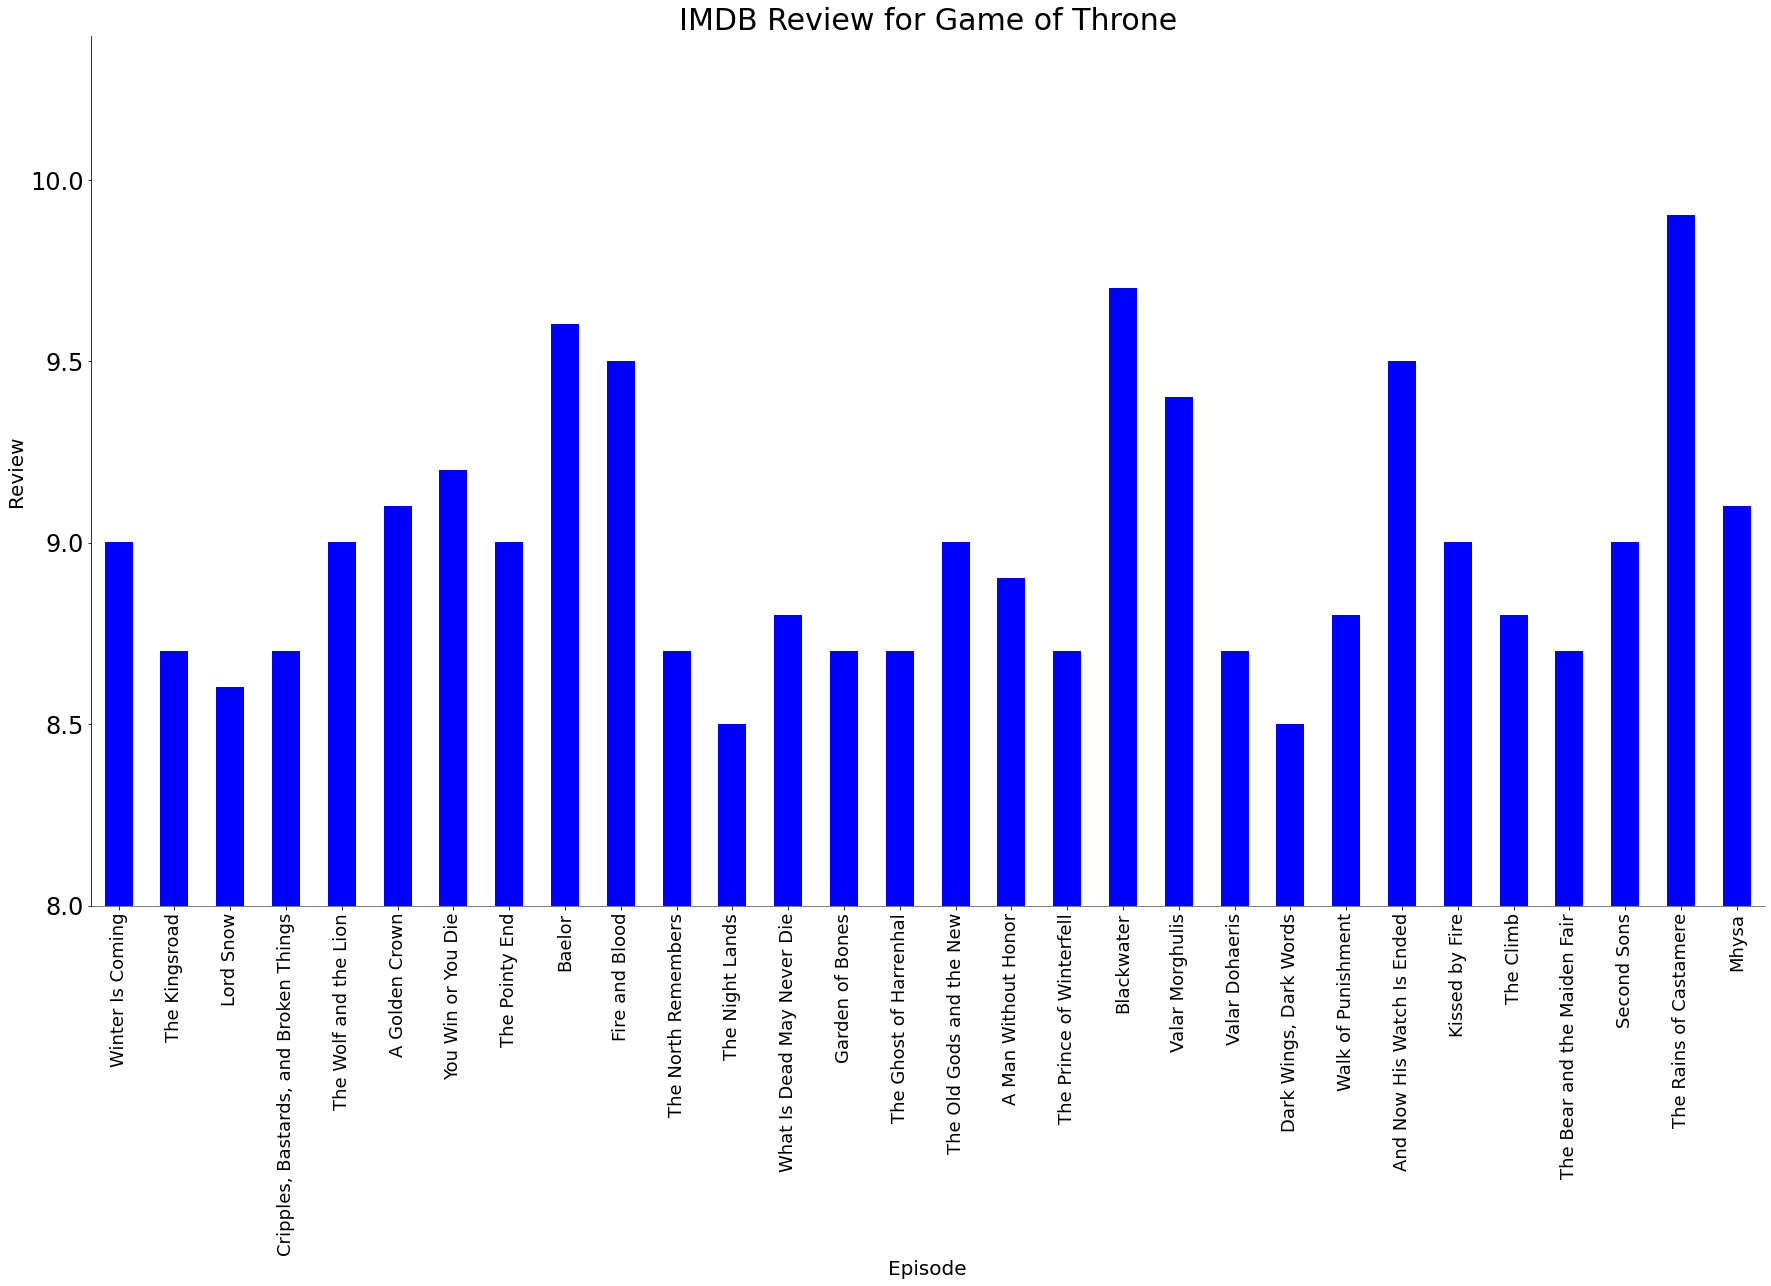

In [219]:
df = GoT_review[["Episode", "Review"]]
ind = df.set_index("Episode", inplace = True)
bar = df.plot(kind='bar',figsize=(30, 16), color = "blue", legend = None)
#bar
plt.yticks(fontsize = 24)
plt.xticks(ind,fontsize = 18)
plt.xlabel("Episode", fontsize = 20)
plt.ylabel("Review", fontsize = 20)
plt.ylim(ymin=8)
plt.title("IMDB Review for Game of Throne", fontsize = 30)
bar.spines['top'].set_visible(False)
bar.spines['right'].set_visible(False)
bar.spines['bottom'].set_linewidth(0.5)
bar.spines['left'].set_visible(True)
plt.show()

# Stength over time

In [308]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def sort_dict_by_value(d, reverse = True):
  return dict(sorted(d.items(), key = lambda x: x[1], reverse = reverse))

def extract_ts(total_strength, ts_strength):
    total_strength = sort_dict_by_value(total_strength)
    #print(total_strength)
  
    first_5_strength = list(total_strength.items())[:5]
    #print(first_3_strength)
    
    strength_series = []
    for i in range(5):
        p_ts = []
        n = first_5_strength[i][0]
        for d in ts_strength:
            try:
                p_ts.append(d[n])
            except:
                p_ts.append(0)
        #print(p_ts, len(p_ts), sum(p_ts))
        strength_series.append(p_ts)
        
    df_ts = pd.DataFrame(
    { first_5_strength[0][0]: strength_series[0], 
      first_5_strength[1][0]: strength_series[1], 
      first_5_strength[2][0]: strength_series[2],
      first_5_strength[3][0]: strength_series[3],
      first_5_strength[4][0]: strength_series[4],})
    
    df_ts.insert(0, 'Scene', range(10, 10+ len(df_ts)*10, 10))
    return df_ts


def plot_ts(df, title, xtitle, ytitle,legendtitle):  
    # Create figure
    fig = go.Figure()

    cols = []
    for col in df.columns:
        if (col != 'Scene'):
            cols.append(col)
    
    # Loop df columns and plot columns to the figure
    for col_name in cols:
        fig.add_trace(go.Scatter(x=df['Scene'], y=df[col_name],
                            mode='lines', # 'lines' or 'markers'
                            name=col_name))

    fig.update_layout(
        title={
            'text': title,
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title=xtitle,
        yaxis_title=ytitle,
        legend_title=legendtitle,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
 
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="RebeccaPurple"
        )
    )
    
    fig.show()
    
    
def plot_ts2(df, title, xtitle ):  
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Scatter(x=df['Scene'], y=df['Nodes'],
                            mode='lines', # 'lines' or 'markers'
                            name='Nodes'), secondary_y=False)

    fig.add_trace(go.Scatter(x=df['Scene'], y=df['Density'],
                            mode='lines', # 'lines' or 'markers'
                            name='Density'), secondary_y=True)
    

    # Add figure title
    fig.update_layout(
        title={
            'text': title,
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    # Set x-axis title
    fig.update_xaxes(title_text=xtitle)

    # Set y-axes titles
    fig.update_yaxes(title_text="Nodes", secondary_y=False)
    fig.update_yaxes(title_text="Density", secondary_y=True)


    fig.show()
    
    
def get_strength_degree(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e,name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
    
    ts_strength = []
    ts_degree   = []
    nodes = set()
 
    for _, v in sorted_x:
 
        g = readG(v, path)
        d = node_dict(g)

        #print(d)
        strength_dic = {}
        degree_dic = {}
        nd = node_dict(g)
        
        for node1, node2, data in g.edges(data=True):
            n1= nd[node1]
            n2= nd[node2]
            nodes.add(n1)
            nodes.add(n2)
            v = data['weight']
            
            try: 
                strength_dic[n1] += v
            except:
                strength_dic[n1] = v
                
            try: 
                strength_dic[n2] += v
            except:
                strength_dic[n2] = v
            
            try:
                degree_dic[n1] += 1
            except:
                degree_dic[n1] = 1
            
            try:
                degree_dic[n2] += 1
            except:
                degree_dic[n2] = 1
            
        
        ts_strength.append(strength_dic)
        ts_degree.append(degree_dic)
        #break
    
 
    #print(ts_strength)
    #print(ts_degree)
    
    total_strength = {}
    total_degree = {}
    
    for d in ts_strength:
        for k in d:
            try:
                total_strength[k] += d[k]
            except:
                total_strength[k]  = d[k]
    
    total_strength = sort_dict_by_value(total_strength)
    #print(total_strength)
    
    for d in ts_degree:
        for k in d:
            try:
                total_degree[k] += d[k]
            except:
                total_degree[k]  = d[k]
    print(total_degree)

    strength_series  = extract_ts(total_strength, ts_strength)
    degree_series  = extract_ts(total_degree, ts_degree)
    return  strength_series, degree_series
 
def get_ts_activenodes(s, e, name = 'GoT_S0', path = 'Data/GoT_dyn_ts10/'):
    edic = episode(s,e,name)
    sorted_x = sorted(edic.items(), key=lambda kv: kv[1])
    
    ts_act_nodes = []
    ts_act_density = []
 
    nodes = set()
 
    for _, v in sorted_x:
        g = readG(v, path)
        d = node_dict(g)
        
        num_nodes = len(get_active_nodes(g))
        ts_act_nodes.append(num_nodes)
        
        sum_weight = 0
        for _, _, data in g.edges(data=True):
            v = data['weight']
            sum_weight += v
            
        sum_edges  = len(g.edges)
        density = 2 * sum_edges / num_nodes / (num_nodes - 1)
 
        ts_act_density.append(density)
    
    df_ts = pd.DataFrame(
    { 'Nodes': ts_act_nodes, 
      'Density': ts_act_density })
    
    df_ts.insert(0, 'Scene', range(10,  10+len(df_ts)*10, 10))
        
    return df_ts
    
    
    
strength_series, degree_series = get_strength_degree(1,1)
 
plot_ts(strength_series, 'Graph Strength Time Series', 'Scene', 'Strength', 'Character')
plot_ts(degree_series, 'Graph Degree Time Sereies', 'Scene', 'Degree', 'Character')

active_node_series = get_ts_activenodes(1,1)
 
plot_ts2(active_node_series, 'Episode 1 Network Nodes and Density Time Sereies', 'Scene')
#active_node_series

{'Jon Snow': 76, 'Brandon Stark': 52, 'Eddard Stark': 122, 'Robb Stark': 50, 'Theon Greyjoy': 60, 'Cersei Lannister': 56, 'Jaime Lannister': 48, 'Catelyn Stark': 94, 'Rodrik Cassel': 20, 'Mordane': 10, 'Sansa Stark': 60, 'Gared': 20, 'Waymar Royce': 20, 'Will': 20, 'Tyrion Lannister': 40, 'Ros': 20, 'Arya Stark': 42, 'Robert Baratheon': 52, 'Daenerys Targaryen': 42, 'Viserys Targaryen': 32, 'Luwin': 30, 'Illyrio Mopatis': 30, 'Benjen Stark': 30, 'Drogo': 20, 'Jorah Mormont': 24, 'Joffrey Baratheon': 2, 'Myrcella Baratheon': 2, 'Sandor Clegane': 2, 'Irri': 2, 'Jhiqui': 2}


# Game of Throne

In [190]:
import pandas as pd
files = os.listdir("Data/GoT_dyn_ts10/")
df_GoT = get_df('GoT.csv',   "Data/GoT_dyn_ts10/",   'GoT_S0', 4, 11,22)
df_GoT = df_GoT.rename(columns={'agg_actnodes': 'Active Characters', 'weighted_density2': 'Weighted Density', 'avg_degrees': "Degree", "avg_strength": "Strength" })
df_GoT

,Episode,Review,Weighted_Density,Active_Nodes,Degrees,Strength,Closeness,Harmonic,Efficiency,Transitivity,Clusters,Components
0,Winter Is Coming,9.001235,0.879977,26,2.846154,10.999712,0.234755,6.862821,0.274513,0.307692,0.328419,3
1,The Kingsroad,8.701235,1.279233,24,2.583333,14.711177,0.259451,7.045833,0.306341,0.141176,0.100000,2
2,Lord Snow,8.601235,0.780416,38,2.684211,14.437690,0.163297,7.097368,0.191821,0.322148,0.420802,3
3,"Cripples, Bastards, and Broken Things",8.701235,0.955038,34,1.941176,15.758127,0.161133,6.119608,0.185443,0.071429,0.083987,3
4,The Wolf and the Lion,9.001235,1.358700,30,2.133333,19.701143,0.174443,5.798889,0.199962,0.172414,0.142963,4
5,A Golden Crown,9.101235,1.335685,32,2.187500,20.703125,0.188658,7.313269,0.235912,0.225806,0.199306,3
6,You Win or You Die,9.201235,1.489819,28,2.000000,20.112551,0.113038,3.333333,0.123457,0.346154,0.366497,6
7,The Pointy End,9.001235,0.469583,41,1.951220,9.391670,0.087089,4.091870,0.102297,0.179104,0.103252,6
8,Baelor,9.601235,1.361319,30,1.733333,19.739130,0.077781,2.488889,0.085824,0.363636,0.222222,8
9,Fire and Blood,9.501235,0.529246,40,1.650000,10.320304,0.079741,3.462500,0.088782,0.107143,0.082024,9


In [191]:
from scipy.stats import pearsonr
get_corr(df_GoT)
#df_GoT

,Network Metrics,Correlation,pValue
0,Weighted_Density,0.228016,0.307451
1,Active_Nodes,-0.458978,0.031661
2,Degrees,-0.167934,0.455045
3,Strength,-0.120952,0.591839
4,Closeness,0.085920,0.703811
5,Harmonic,-0.185980,0.407290
6,Efficiency,0.070941,0.753736
7,Transitivity,-0.030217,0.893808
8,Clusters,-0.176352,0.432416
9,Components,-0.011451,0.959664


In [192]:
get_corr_spearman(df_GoT)

,Network Metrics,Correlation,pValue
0,Weighted_Density,0.314303,0.154285
1,Active_Nodes,-0.500789,0.017599
2,Degrees,-0.048368,0.830744
3,Strength,0.010362,0.963498
4,Closeness,0.179026,0.425356
5,Harmonic,-0.134701,0.550067
6,Efficiency,0.126067,0.576143
7,Transitivity,-0.035114,0.876715
8,Clusters,-0.157152,0.484903
9,Components,-0.066844,0.767569


In [193]:
import seaborn as sns
ax = sns.lmplot(x='Number of Active Characters', y="Review", data=df_GoT);
#ax.set_title("Active Nodes vs Review")
#ax.set_xlabel("Number of Active Nodes")
#sns.lmplot(x="agg_actnodes", y="Review", hue="AirEntrain", data=df_GoT);

KeyError: "['Number of Active Characters'] not in index"

# House of Cards

In [194]:
files = os.listdir("Data/HoC_dyn_ts10")
df_hoc = get_df('HoC.csv', "Data/HoC_dyn_ts10/",  'HoC_S0', 3, 14, 26)
df_hoc

,Episode,Review,Weighted_Density,Active_Nodes,Degrees,Strength,Closeness,Harmonic,Efficiency,Transitivity,Clusters,Components
0,Chapter 1,8.601235,1.207103,24,2.083333,13.881687,0.379382,9.770833,0.424819,0.070588,0.119444,1
1,Chapter 2,8.501235,1.032492,26,2.153846,12.906154,0.380303,10.671795,0.426872,0.051724,0.102987,1
2,Chapter 3,8.301235,1.574021,22,2.000000,16.527222,0.387877,8.765152,0.417388,0.051724,0.189827,2
3,Chapter 4,8.201235,0.981159,27,2.074074,12.755071,0.324275,9.488889,0.364957,0.092784,0.207969,2
4,Chapter 5,8.401235,0.792796,29,2.275862,11.099147,0.356802,11.305747,0.403777,0.122951,0.078176,1
5,Chapter 6,8.501235,1.564426,22,2.272727,16.426470,0.370050,8.568182,0.408009,0.140187,0.251399,2
6,Chapter 7,8.101235,1.056570,28,2.428571,14.263700,0.362363,10.779762,0.399250,0.147239,0.179422,2
7,Chapter 8,7.701235,3.157255,15,2.000000,22.100785,0.281975,4.400000,0.314286,0.171429,0.117460,2
8,Chapter 9,8.501235,1.837056,22,2.545455,19.289084,0.403324,9.643939,0.459235,0.150000,0.304293,1
9,Chapter 10,8.701235,1.795357,20,2.500000,17.055894,0.454069,9.500000,0.500000,0.153846,0.246062,1


In [195]:
get_corr(df_hoc)

,Network Metrics,Correlation,pValue
0,Weighted_Density,0.089816,0.662594
1,Active_Nodes,-0.142668,0.486893
2,Degrees,-0.087954,0.669197
3,Strength,0.107916,0.599765
4,Closeness,0.165582,0.418870
5,Harmonic,0.012449,0.951869
6,Efficiency,0.243479,0.230689
7,Transitivity,-0.249218,0.219539
8,Clusters,-0.255414,0.207914
9,Components,-0.200630,0.325733


In [196]:
get_corr_spearman(df_hoc)

,Network Metrics,Correlation,pValue
0,Weighted_Density,0.264401,0.191807
1,Active_Nodes,-0.297138,0.140446
2,Degrees,-0.090547,0.660011
3,Strength,0.205453,0.313991
4,Closeness,0.161674,0.430085
5,Harmonic,-0.169258,0.408469
6,Efficiency,0.302320,0.133329
7,Transitivity,-0.099658,0.628119
8,Clusters,-0.216140,0.288918
9,Components,-0.313916,0.118355


# Breaking Bad

In [197]:
files = os.listdir("Data/BB_dyn_ts10")
df_bb = get_df('BB.csv', "Data/BB_dyn_ts10/",  'BB_S0', 4, 14, 26)
df_bb

1 8
1 9
1 10
1 11
1 12
1 13
3 7
3 8
3 9
3 10
3 11
3 12
3 13


,Episode,Review,Weighted_Density,Active_Nodes,Degrees,Strength,Closeness,Harmonic,Efficiency,Transitivity,Clusters,Components
0,Pilot,9.001235,7.243874,12,2.000000,39.841304,0.473766,5.819444,0.529040,0.088235,0.114087,1
1,Cat's in the Bag...,8.601235,81.456667,4,2.000000,122.185000,0.775000,2.500000,0.833333,0.600000,0.583333,1
2,...And the Bag's in the River,8.701235,14.267550,11,2.000000,71.337752,0.383229,4.869697,0.486970,0.150000,0.121212,1
3,Cancer Man,8.201235,2.123505,22,2.727273,22.296802,0.404725,9.727273,0.463203,0.284483,0.363961,1
4,Gray Matter,8.301235,4.625012,15,2.266667,32.375083,0.411813,6.773333,0.483810,0.180000,0.146825,1
5,Crazy Handful of Nothin',9.301235,5.157157,14,2.142857,33.521519,0.443245,6.535714,0.502747,0.142857,0.195578,1
6,A No-Rough-Stuff-Type Deal,8.801235,5.754367,13,1.692308,34.526201,0.274706,3.876923,0.323077,0.000000,0.000000,2
7,Seven Thirty-Seven,8.601235,21.428122,7,2.285714,64.284365,0.580539,3.952381,0.658730,0.375000,0.285714,1
8,Grilled,9.301235,10.663760,11,2.545455,53.318800,0.510917,5.787879,0.578788,0.307692,0.427273,1
9,Bit by a Dead Bee,8.301235,3.878651,17,2.823529,31.029206,0.477503,8.509804,0.531863,0.264706,0.351261,1


In [198]:
get_corr(df_bb)

,Network Metrics,Correlation,pValue
0,Weighted_Density,0.051398,0.803087
1,Active_Nodes,-0.278249,0.168705
2,Degrees,-0.030753,0.881448
3,Strength,0.160387,0.433815
4,Closeness,-0.003959,0.984685
5,Harmonic,-0.313294,0.119125
6,Efficiency,-0.019377,0.925146
7,Transitivity,0.139597,0.496415
8,Clusters,0.192825,0.345291
9,Components,0.143215,0.485206


In [199]:
get_corr_spearman(df_bb)

,Network Metrics,Correlation,pValue
0,Weighted_Density,0.297393,0.140090
1,Active_Nodes,-0.299561,0.137085
2,Degrees,0.047586,0.817439
3,Strength,0.273698,0.176070
4,Closeness,-0.001374,0.994686
5,Harmonic,-0.269920,0.182352
6,Efficiency,-0.013050,0.949551
7,Transitivity,0.209172,0.305118
8,Clusters,0.233519,0.250920
9,Components,0.223133,0.273215


# GETTING REVIEWS FROM IMDB

House of Cards


,Episode,Review
0,Chapter 1,8.601235
1,Chapter 2,8.501235
2,Chapter 3,8.301235
3,Chapter 4,8.201235
4,Chapter 5,8.401235
5,Chapter 6,8.501235
6,Chapter 7,8.101235
7,Chapter 8,7.701235
8,Chapter 9,8.501235
9,Chapter 10,8.701235


In [348]:
HoC_review = get_review("1856010", 3, 14)
HoC_review.to_csv("HoC.csv")
GoT_review = get_review("0944947", 4, 11)
GoT_review.to_csv("GoT.csv")
BB_review = get_review("0903747", 4, 14)
BB_review.to_csv("BB.csv")


House of Cards
Game of Thrones
Breaking Bad


In [349]:
HoC_review = pd.read_csv('BB.csv')  
HoC_review.drop('Unnamed: 0', 1)

,Episode,Review
0,Pilot,9.001235
1,Cat's in the Bag...,8.601235
2,...And the Bag's in the River,8.701235
3,Cancer Man,8.201235
4,Gray Matter,8.301235
5,Crazy Handful of Nothin',9.301235
6,A No-Rough-Stuff-Type Deal,8.801235
7,Seven Thirty-Seven,8.601235
8,Grilled,9.301235
9,Bit by a Dead Bee,8.301235


In [350]:
BB_review = get_review("0903747", 4, 14)
BB_review

Breaking Bad


,Episode,Review
0,Pilot,9.001235
1,Cat's in the Bag...,8.601235
2,...And the Bag's in the River,8.701235
3,Cancer Man,8.201235
4,Gray Matter,8.301235
5,Crazy Handful of Nothin',9.301235
6,A No-Rough-Stuff-Type Deal,8.801235
7,Seven Thirty-Seven,8.601235
8,Grilled,9.301235
9,Bit by a Dead Bee,8.301235


In [ ]:
import imdb

# creating instance of IMDb
ia = imdb.IMDb()
 
def get_review(code, num_seasons, num_epsodes):
    # id
    #code = "1856010"

    # getting information
    series = ia.get_movie(code)

    # adding new info set
    ia.update(series, 'episodes')

    # getting episodes of the series
    episodes = series.data['episodes']

    # printing the object i.e name
    print(series)

    dict = {'Episode':[],
            'Review':[]
           }

    # getting season
    for s in range(1,num_seasons):
        season = episodes[s]

        # getting single episode of season
        for i in range(1,num_epsodes):
            try:
                epi = season[i]

                # getting id and printing it
                #print(epi['title'], epi.data['rating'])
                dict['Episode'].append(epi['title'])
                dict['Review'].append(epi.data['rating'])
            except:
                pass

    df_review = pd.DataFrame(dict)
    return df_review

HoC_review = get_review("1856010", 3, 14)
HoC_review